# Taiwanese Credit Card Default Modeling.

The goal of this project to find a model which best predicts whether or not a person will default on their credit card payment. 

#### Data Set Information:

- This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

- NT is the abbreviation for New Taiwan.

#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 
    

Median salary by education level:

1. Graduate school and above = 831496
2. University = 575575
3. Junior college = 526270
4. Senior high school = 417073
5. Junior high school = 394230
6. Primary school, Supplementary school and illiteracy = 292370

References:

https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end

https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

https://win.dgbas.gov.tw/fies/e12.asp?year=94

# Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

## Helper Functions

In [4]:
def heatmap_corr(dataframe):
    # Plots a heatmap of correlation between features with masking.
    fig, ax = plt.subplots(figsize=(20,20))
    mask=np.zeros_like(dataframe.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    color_map = sns.color_palette("hot_r")
    ax = sns.heatmap(dataframe.corr(), cmap = color_map, mask=mask, square=True, annot=True)

def knnTrainTest(k_number, X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k_number)
    # train
    knn.fit(X_train, y_train)
    # test
    y_pred_class = knn.predict(X_test)


    # check Accuracy
    print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))
    # check F1 score
    print('Test F1 score: ', f1_score(y_test, y_pred_class))
    return y_pred_class

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def logiRegr(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    # examine coefficients
    # print(zip(X_train.columns, logreg.coef_[0]))
    # print(logreg.coef_)
    # class predictions (not predicted probabilities)
    y_pred_class = logreg.predict(X_test)
    print('Classification Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print('Test F1 score: ', f1_score(y_test, y_pred_class))
    # plot confusion matrix
    cm = confusion_matrix(y_test,y_pred_class)
    classes = ['NON-default','DEFAULT']
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    
def deciTree(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier() # Create Decision Tree classifer object
    clf = clf.fit(X_train,y_train) # Train Decision Tree Classifer
    y_pred_train = clf.predict(X_train) #predict the training set
    y_pred_test = clf.predict(X_test) #Predict the response for test dataset

    # Model Accuracy, how often is the classifier correct?
    print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
    print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))

def gridHyper(estimator, params, cv, scoring, X_train, y_train, X_test, y_test):
    gridSearch = GridSearchCV(estimator, params, cv=cv, scoring=scoring) #create the instance of GridSearchCV
    gridSearch.fit(X_train,y_train) #fit the Gridsearch to our data
    # examine the best model
    print('Training Best Score: ', gridSearch.best_score_, '\n')
    print('Training Best Params: v \n', gridSearch.best_params_, '\n\n')
    print('Training Best Estimator: v \n', gridSearch.best_estimator_, '\n\n')
    
    
    # Use the best estimator to predict the response for test dataset
    y_pred = gridSearch.best_estimator_.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Testing Accuracy:", metrics.f1_score(y_test, y_pred))
    return y_pred

## 1. Data Prep

In [25]:
df = pd.read_csv('classification_lab_data.csv')

In [26]:
df.head(30)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,50000,1,2,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1
1,30000,1,2,1,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0
2,260000,1,1,2,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0
3,200000,2,2,1,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0
4,50000,1,1,2,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0
5,150000,2,1,1,46,0,0,0,0,0,0,21787,22817,24134,24635,29032,29766,1382,1699,1200,5000,1214,1500,0
6,400000,2,2,2,41,-2,-2,-2,-2,-2,-2,43672,678,330,330,330,330,678,330,330,330,330,330,1
7,360000,2,2,2,31,0,-1,-1,-1,-2,-2,3386,5964,1340,1650,4350,4792,5964,1340,1650,4350,4792,40682,0
8,160000,2,2,2,32,2,2,2,2,-1,0,400,400,400,0,20818,20818,0,0,0,20818,0,0,0
9,500000,2,1,1,44,0,-1,-1,0,0,0,329570,71921,367979,294969,189612,128459,72001,368199,6486,234,90,167116,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 24 columns):
LIMIT_BAL                     23999 non-null int64
SEX                           23999 non-null int64
EDUCATION                     23999 non-null int64
MARRIAGE                      23999 non-null int64
AGE                           23999 non-null int64
PAY_0                         23999 non-null int64
PAY_2                         23999 non-null int64
PAY_3                         23999 non-null int64
PAY_4                         23999 non-null int64
PAY_5                         23999 non-null int64
PAY_6                         23999 non-null int64
BILL_AMT1                     23999 non-null int64
BILL_AMT2                     23999 non-null int64
BILL_AMT3                     23999 non-null int64
BILL_AMT4                     23999 non-null int64
BILL_AMT5                     23999 non-null int64
BILL_AMT6                     23999 non-null int64
PAY_AMT1                

In [28]:
df.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [29]:
df[df.duplicated(keep="first")].count()

LIMIT_BAL                     21
SEX                           21
EDUCATION                     21
MARRIAGE                      21
AGE                           21
PAY_0                         21
PAY_2                         21
PAY_3                         21
PAY_4                         21
PAY_5                         21
PAY_6                         21
BILL_AMT1                     21
BILL_AMT2                     21
BILL_AMT3                     21
BILL_AMT4                     21
BILL_AMT5                     21
BILL_AMT6                     21
PAY_AMT1                      21
PAY_AMT2                      21
PAY_AMT3                      21
PAY_AMT4                      21
PAY_AMT5                      21
PAY_AMT6                      21
default payment next month    21
dtype: int64

In [30]:
dups = list(df[df.duplicated(keep="first")].index.values)
df.drop(df.index[dups],inplace=True)

In [31]:
df.reset_index(drop=True, inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23978 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL                     23978 non-null int64
SEX                           23978 non-null int64
EDUCATION                     23978 non-null int64
MARRIAGE                      23978 non-null int64
AGE                           23978 non-null int64
PAY_0                         23978 non-null int64
PAY_2                         23978 non-null int64
PAY_3                         23978 non-null int64
PAY_4                         23978 non-null int64
PAY_5                         23978 non-null int64
PAY_6                         23978 non-null int64
BILL_AMT1                     23978 non-null int64
BILL_AMT2                     23978 non-null int64
BILL_AMT3                     23978 non-null int64
BILL_AMT4                     23978 non-null int64
BILL_AMT5                     23978 non-null int64
BILL_AMT6                     23978 non-null int64
PAY_AMT1                

## 2. EDA

In [33]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,23978.000000,23978.000000,23978.000000,23978.000000,23978.00000,23978.000000,23978.000000,23978.000000,23978.000000,23978.000000,23978.000000,23978.000000,23978.000000,2.397800e+04,23978.000000,23978.000000,23978.000000,23978.000000,2.397800e+04,23978.00000,23978.000000,23978.000000,23978.000000,23978.000000
mean,167785.873718,1.603595,1.857161,1.550755,35.52544,-0.015014,-0.133497,-0.164401,-0.215906,-0.260197,-0.284719,51634.054759,49564.907582,4.751624e+04,43834.785178,40783.574652,39261.045625,5692.608474,6.024750e+03,5257.83072,4828.623029,4829.166611,5250.144132,0.221286
std,129917.562562,0.489161,0.791944,0.522455,9.25501,1.120667,1.192413,1.192697,1.167915,1.132201,1.149631,74120.952128,71567.634780,7.002747e+04,64943.040121,61272.587362,60090.720542,16704.997497,2.455148e+04,17974.24672,15737.017925,15602.780318,17802.913907,0.415121
min,10000.000000,1.000000,0.000000,0.000000,21.00000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-67526.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3597.250000,2985.250000,2.752250e+03,2400.000000,1823.000000,1299.000000,1000.000000,8.800000e+02,396.00000,300.000000,277.000000,138.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22518.500000,21352.000000,2.026200e+04,19166.500000,18254.500000,17201.000000,2116.500000,2.014000e+03,1815.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67841.500000,64674.000000,6.099800e+04,55495.500000,50641.500000,49480.250000,5021.000000,5.000000e+03,4576.75000,4092.750000,4036.750000,4011.750000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [34]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [35]:
df.rename({'PAY_6': 'Payment_Status_Apr', 'PAY_5': 'Payment_Status_May', 'PAY_4': 'Payment_Status_Jun', 
           'PAY_3': 'Payment_Status_Jul', 'PAY_2': 'Payment_Status_Aug', 'PAY_0': 'Payment_Status_Sep',
           'BILL_AMT6': 'Bill_Apr', 'BILL_AMT5': 'Bill_May', 'BILL_AMT4': 'Bill_Jun',
           'BILL_AMT3': 'Bill_Jul', 'BILL_AMT2': 'Bill_Aug', 'BILL_AMT1': 'Bill_Sep',
           'PAY_AMT6': 'Payments_Apr', 'PAY_AMT5': 'Payments_May', 'PAY_AMT4': 'Payments_Jun',
           'PAY_AMT3': 'Payments_Jul', 'PAY_AMT2': 'Payments_Aug', 'PAY_AMT1': 'Payments_Sep',
           'default payment next month': 'defaulted'}, axis=1, inplace=True)

In [36]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'Payment_Status_Sep', 'Payment_Status_Aug', 'Payment_Status_Jul',
       'Payment_Status_Jun', 'Payment_Status_May', 'Payment_Status_Apr',
       'Bill_Sep', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr',
       'Payments_Sep', 'Payments_Aug', 'Payments_Jul', 'Payments_Jun',
       'Payments_May', 'Payments_Apr', 'defaulted'],
      dtype='object')

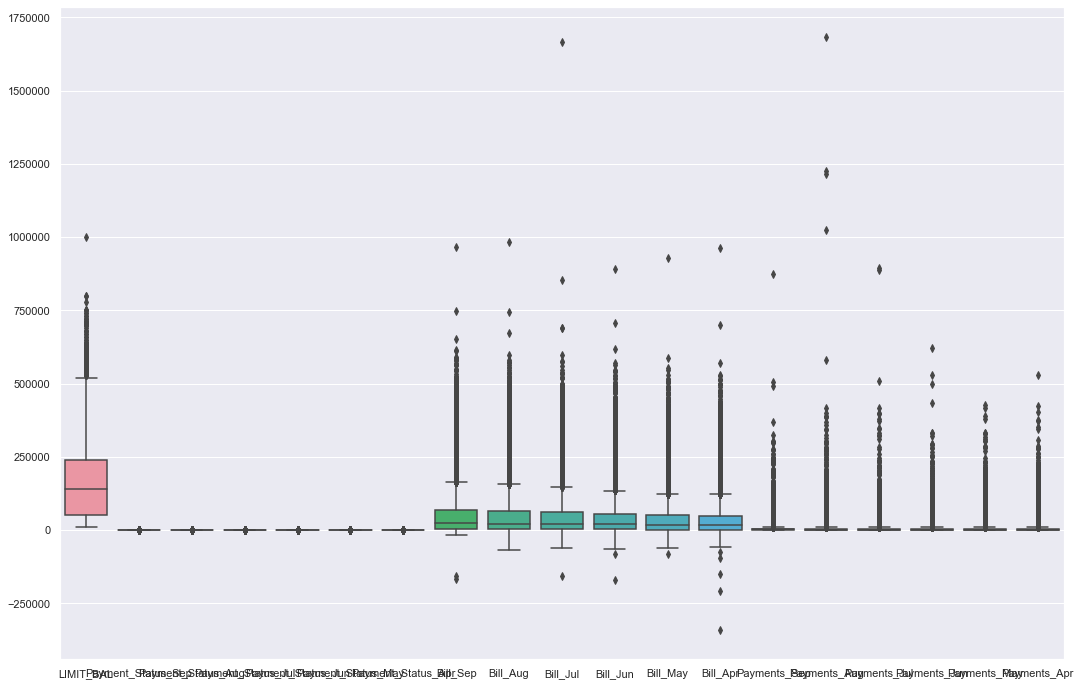

In [37]:
cols = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'defaulted'], axis=1)
sns.set(rc={'figure.figsize':(18,12)})
sns.boxplot(data=cols)

In [38]:
df = df[(np.abs(stats.zscore(df)) < 4).all(axis=1)]

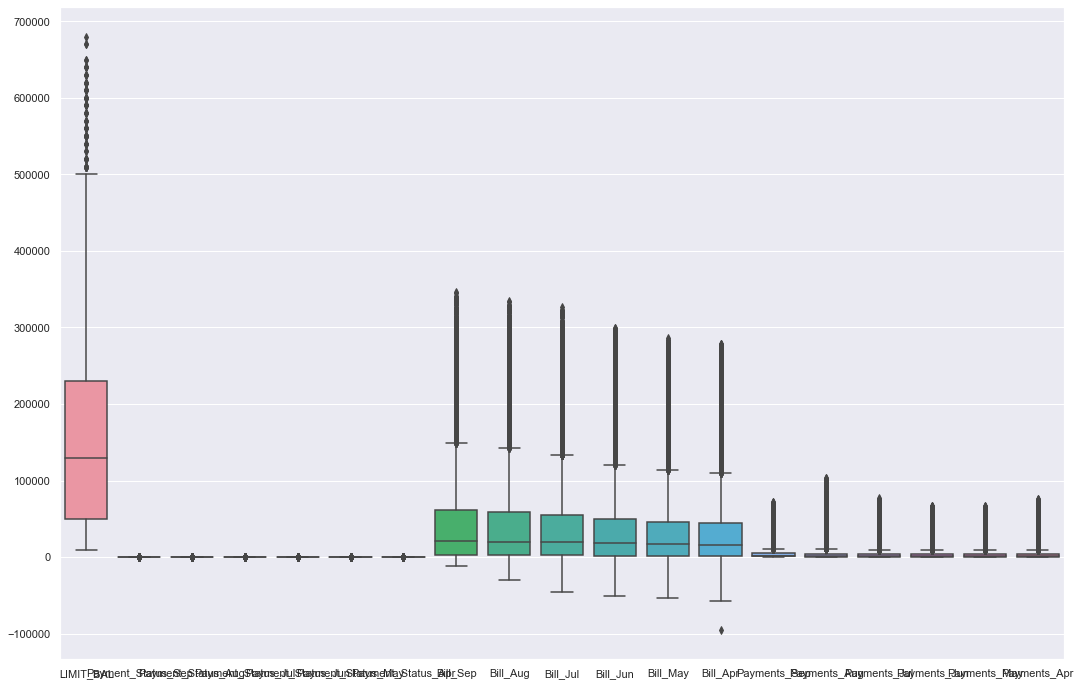

In [39]:
cols = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'defaulted'], axis=1)
sns.set(rc={'figure.figsize':(18,12)})
sns.boxplot(data=cols)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22327 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL             22327 non-null int64
SEX                   22327 non-null int64
EDUCATION             22327 non-null int64
MARRIAGE              22327 non-null int64
AGE                   22327 non-null int64
Payment_Status_Sep    22327 non-null int64
Payment_Status_Aug    22327 non-null int64
Payment_Status_Jul    22327 non-null int64
Payment_Status_Jun    22327 non-null int64
Payment_Status_May    22327 non-null int64
Payment_Status_Apr    22327 non-null int64
Bill_Sep              22327 non-null int64
Bill_Aug              22327 non-null int64
Bill_Jul              22327 non-null int64
Bill_Jun              22327 non-null int64
Bill_May              22327 non-null int64
Bill_Apr              22327 non-null int64
Payments_Sep          22327 non-null int64
Payments_Aug          22327 non-null int64
Payments_Jul          22327 non-null int64
Payments_Jun          22327 non

In [41]:
df.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,defaulted
LIMIT_BAL,1.000000,0.035262,-0.232984,-0.110221,0.129372,-0.285624,-0.313460,-0.307553,-0.291064,-0.274958,-0.260282,0.180200,0.167266,0.170288,0.175169,0.175233,0.165411,0.215984,0.213071,0.224753,0.218604,0.214528,0.220184,-0.152856
SEX,0.035262,1.000000,0.011540,-0.033651,-0.092036,-0.053774,-0.069009,-0.064161,-0.057638,-0.051697,-0.042842,-0.022721,-0.021293,-0.017750,-0.011050,-0.006059,-0.003829,0.002744,0.003448,0.015883,0.016518,0.020056,0.025913,-0.041004
EDUCATION,-0.232984,0.011540,1.000000,-0.145929,0.182215,0.106844,0.124930,0.116302,0.109432,0.099348,0.083472,0.030041,0.029438,0.022554,0.012070,0.003059,0.003353,-0.054203,-0.055656,-0.058097,-0.060978,-0.057637,-0.058716,0.028319
MARRIAGE,-0.110221,-0.033651,-0.145929,1.000000,-0.409185,0.021252,0.027712,0.038885,0.041475,0.044224,0.041817,-0.012888,-0.009671,-0.008947,-0.010010,-0.010484,-0.011024,-0.006542,-0.001108,-0.006691,-0.009666,-0.011086,0.000530,-0.020002
AGE,0.129372,-0.092036,0.182215,-0.409185,1.000000,-0.041833,-0.049208,-0.052776,-0.053156,-0.059024,-0.054664,0.030465,0.027756,0.026736,0.023519,0.021286,0.020511,0.019051,0.017444,0.020174,0.024373,0.023895,0.011512,0.012267
Payment_Status_Sep,-0.285624,-0.053774,0.106844,0.021252,-0.041833,1.000000,0.646953,0.551940,0.522064,0.497891,0.469431,0.208930,0.219087,0.217887,0.220574,0.221450,0.220922,-0.103024,-0.102055,-0.095835,-0.079851,-0.080000,-0.079242,0.322319
Payment_Status_Aug,-0.313460,-0.069009,0.124930,0.027712,-0.049208,0.646953,1.000000,0.760817,0.656360,0.621807,0.581804,0.270892,0.277335,0.275874,0.276490,0.275041,0.273421,-0.090880,-0.063923,-0.058047,-0.044303,-0.034522,-0.043158,0.256082
Payment_Status_Jul,-0.307553,-0.064161,0.116302,0.038885,-0.052776,0.551940,0.760817,1.000000,0.765194,0.672442,0.620215,0.251288,0.285050,0.285054,0.287813,0.286687,0.284726,0.028555,-0.085612,-0.055069,-0.040325,-0.027397,-0.039146,0.228420
Payment_Status_Jun,-0.291064,-0.057638,0.109432,0.041475,-0.053156,0.522064,0.656360,0.765194,1.000000,0.801334,0.692963,0.256083,0.285127,0.311858,0.315599,0.313911,0.313441,0.014793,0.028875,-0.075612,-0.033352,-0.010472,-0.022962,0.207970
Payment_Status_May,-0.274958,-0.051697,0.099348,0.044224,-0.059024,0.497891,0.621807,0.672442,0.801334,1.000000,0.799447,0.259627,0.286043,0.311265,0.341403,0.342295,0.339036,0.010725,0.022011,0.049288,-0.048144,-0.006298,-0.013534,0.190335
